# EVO-SPOTIS - recommendation and decision support system based on based on the stochastic evolutionary algorithm Differential Evolution algorithm and the SPOTIS method
This manual explains software that provides the EVO-SPOTIS multi-criteria decision support system that gives recommendations using the SPOTIS multi-criteria decision-making method using criteria weights determined by the Differential Evolution algorithm based on data and historical rankings for an analogous decision problem.

Import the necessary libraries and modules

In [1]:
import numpy as np
import pandas as pd
import copy

from rank_preferences import *
from correlations import *
from weighting_methods import *
from spotis import SPOTIS
from de import DE_algorithm
from visualization import *

The 21 evaluation criteria for mobile phones are presented below. Goal represents a criteria type that can be Profit (1) or Cost (-1) The purpose of the implemented tool is to identify the values of the weights of these criteria and use them for multi-criteria evaluation of an analogous set of alternatives, for which the weights and ratings are unknown.

In [5]:
criteria_phones = 'input/criteria_phones.csv'
df_crit = pd.read_csv(criteria_phones, index_col = ('Cj'))
pd.set_option('max_colwidth', None)
df_crit

,Symbol,Name,Explanation,Goal
Cj,,,,
C1,battery_power,Battery power,Total energy a battery can store in one time measured in mAh,1
C2,blue,Blue,Has bluetooth or not,1
C3,clock_speed,Clock speed,Speed at which microprocessor executes instructions,1
C4,dual_sim,Dual sim,Has dual sim support or not,1
C5,fc,Fc (Front camera),Front Camera mega pixels,1
C6,four_g,Four G,Has 4G or not,1
C7,int_memory,Internal memory,Internal Memory in Gigabytes,1
C8,m_dep,Mobile depth,Mobile Depth in cm,-1
C9,mobile_wt,Mobile weight,Weight of mobile phone,-1


Load dataset. In this case, the training dataset and the test dataset will be extracted from data on the first 200 mobile phones from the dataset containing 2000 samples. Be aware that the training dataset must have a large enough size for the algorithm to work effectively, such as 100 samples. The last row of the CSV file contains the criterion types, where 1 is the profit criterion, and -1 is the cost criterion.

In [2]:
filename = 'input/mobile_phones2000.csv'
data = pd.read_csv(filename)
types = data.iloc[len(data) - 1, :].to_numpy()
df_data = data.iloc[:200, :]
whole_matrix = df_data.to_numpy()

The SPOTIS method was chosen as a multi-criteria method for evaluating alternatives in this system. For this method, bounds containing minimum and maximum constraints on the performance values of the alternatives with respect to the corresponding criteria have to be determined. This procedure represents the definition of the problem space by the decision-maker. It ensures that there will be no reversal of the ranking of the alternatives when the training and test datasets are evaluated individually. Bounds need not be the de facto minima and maxima of the decision matrix but may be determined by the decision-maker depending on the problem.

In [3]:
# determine bounds of alternatives performances for SPOTIS
bounds_min = np.amin(whole_matrix, axis = 0)
bounds_max = np.amax(whole_matrix, axis = 0)
bounds = np.vstack((bounds_min, bounds_max))

Provide the training dataset (X_train) and the test dataset (X_test). The training dataset is displayed below. The columns contain the names of the criteria, and the rows include the symbols of the alternatives. The last column, named Rank, contains the expert ranking (y_train).

In [4]:
# load train and test datasets
train_df = pd.read_csv('input/train.csv', index_col = 'Ai')
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,Rank
Ai,,,,,,,,,,,,,,,,,,,,,
$A_{1}$,1840.0,0.0,0.5,1.0,12.0,0.0,34.0,0.7,142.0,1.0,...,1545.0,1078.0,8.0,0.0,10.0,0.0,0.0,0.0,1.0,145.0
$A_{2}$,1156.0,1.0,1.2,1.0,0.0,1.0,50.0,0.8,159.0,2.0,...,547.0,470.0,7.0,0.0,15.0,1.0,1.0,0.0,0.0,46.0
$A_{3}$,748.0,1.0,1.7,0.0,0.0,1.0,27.0,0.9,150.0,8.0,...,1554.0,2126.0,18.0,9.0,7.0,1.0,0.0,0.0,1.0,100.0
$A_{4}$,1514.0,0.0,2.9,0.0,0.0,0.0,27.0,0.2,118.0,3.0,...,1810.0,1152.0,8.0,3.0,20.0,0.0,1.0,1.0,1.0,123.0
$A_{5}$,1602.0,1.0,2.8,1.0,4.0,1.0,38.0,0.7,114.0,3.0,...,788.0,1037.0,8.0,7.0,20.0,1.0,0.0,0.0,0.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
$A_{157}$,1678.0,0.0,2.1,0.0,3.0,1.0,64.0,0.9,134.0,3.0,...,536.0,278.0,19.0,0.0,10.0,1.0,1.0,0.0,0.0,112.0
$A_{158}$,1308.0,0.0,1.3,1.0,8.0,0.0,46.0,0.9,199.0,1.0,...,989.0,488.0,5.0,3.0,9.0,0.0,1.0,0.0,0.0,125.0
$A_{159}$,1831.0,0.0,1.4,1.0,2.0,0.0,43.0,0.9,150.0,5.0,...,1381.0,3834.0,17.0,7.0,13.0,1.0,1.0,1.0,3.0,77.0


In [5]:
X_train = train_df.iloc[:len(train_df) - 1, :-1].to_numpy()
y_train = train_df.iloc[:len(train_df) - 1, -1].to_numpy()

test_df = pd.read_csv('input/test.csv', index_col = 'Ai')
X_test = test_df.iloc[:len(test_df) - 1, :-1].to_numpy()
y_test = test_df.iloc[:len(test_df) - 1, -1].to_numpy()

The performance dataset represents the training features (X_train), and the ranking of alternatives represents the target variable (y_train). The expert weights are usually implicit, and the DE algorithm generates them based on the known ranking of the training set. In this case, the expert weights determined by the Entropy method are provided for comparison with the weights generated by the algorithm for research purposes.

In [6]:
# real weights
train_weights = entropy_weighting(X_train)
cols = [r'$C_{' + str(y) + '}$' for y in range(1, data.shape[1] + 1)]
pd_weights = pd.DataFrame(index = cols)

Run the DE algorithm. The class containing this algorithm and all the methods needed to run it are included in the de.py file. You can decide if you want to display the best value of the fitness function in each iteration of the algorithm by setting the verbose parameter to True (the default setting) or choosing not to display it by setting verbose to False. The setting parameters of the DE algorithm are initialized in the __init__ method that initializes an object of de_algorithm. The DE algorithm takes as arguments the data frame for weights (pd_weights) for visualization, decision matrix with training samples (X_train), an expert ranking determined for the learning set (y_train), criteria types, and bounds. The DE algorithm returns the completed pd_weights, the generated weights (BestPosition of the best individual in population), the best and average fitness function values in successive DE iterations.

In [7]:
# DE algorithm
de_algorithm = DE_algorithm()
pd_weights, BestPosition, BestFitness, MeanFitness = de_algorithm(pd_weights, X_train, y_train, types, bounds, verbose = False)

Check the results of the algorithm. Skip the following step if you do not have expert weights for the training dataset.

Weights correlation:  0.9997416589313192


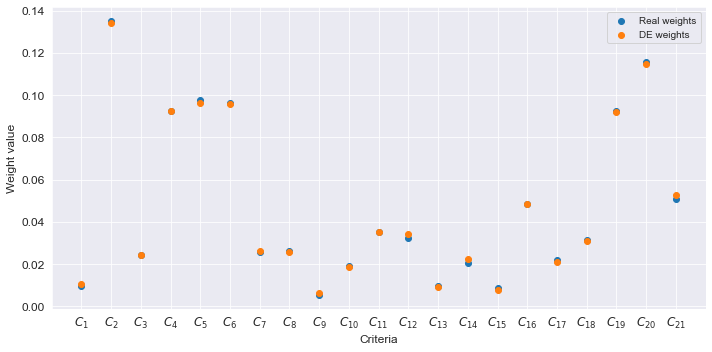

In [8]:
# Results
weights = pd.DataFrame(index = cols)
weights['Real weights'] = train_weights
weights['DE weights'] = BestPosition
weights = weights.rename_axis('Cj')
weights.to_csv('output/best_weights_de.csv')

print('Weights correlation: ', pearson_coeff(train_weights, BestPosition))
plot_weights(weights)

Save and visualize the results of the best and mean fitness function values in subsequent iterations.

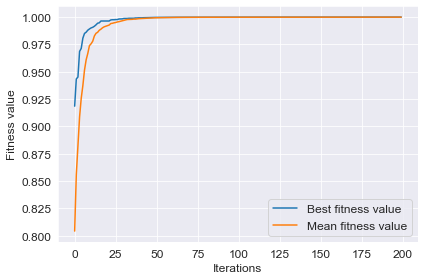

In [9]:
fitness_best = pd.DataFrame()
fitness_best['Best fitness value'] = BestFitness
fitness_best.to_csv('output/best_fitness.csv')

fitness_mean = pd.DataFrame()
fitness_mean['Mean fitness value'] = MeanFitness
fitness_mean.to_csv('output/mean_fitness.csv')

plot_fitness(BestFitness, MeanFitness)

The final stage of this research involves determining the ranking (y_pred) for mobile phones from the test dataset (X_test) using the criterion weights determined by the DE algorithm (BestPosition - since the values represent the position of the best individual in the population after running the evolutionary algorithm, represent the criterion weights). Next, both rankings, namely real (y_test) and predicted (y_pred) are compared using the Spearman rank correlation coefficient. A comparison of the rankings to determine their convergence is visualized in the chart.

Rankings consistency:  0.999812382739212


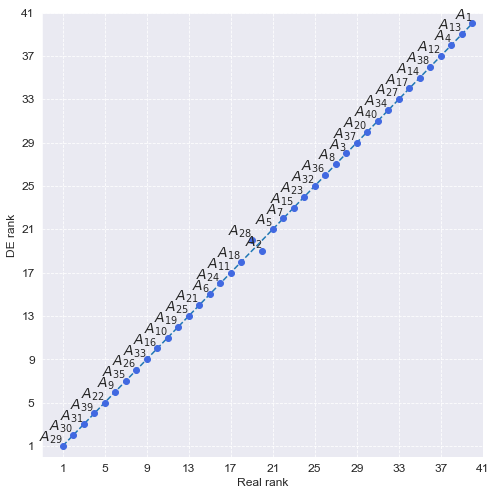

In [10]:
# Ranking
spotis = SPOTIS()
pref = spotis(X_test, BestPosition, types, bounds)
y_pred = rank_preferences(pref, reverse = False)
print('Rankings consistency: ', spearman(y_test, y_pred))

results = pd.DataFrame(index = test_df.index[:-1])
results['Real rank'] = y_test
results['DE rank'] = y_pred
results.to_csv('output/results_de.csv')

plot_rankings(results)